In [1]:
pip install -U torch  ultralytics

Note: you may need to restart the kernel to use updated packages.


In [7]:
# import & downloading the sam weights
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.2
Torchvision version: 0.16.2
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/b0/dyxm6nf10l150qlhb6kl1yl40000gn/T/pip-req-build-5c4z50kd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/b0/dyxm6nf10l150qlhb6kl1yl40000gn/T/pip-req-build-5c4z50kd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-12-30 16:02:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.74.118, 13.227.74.9, 13.227.74.12, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.74.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pt


0: 416x640 1 cup, 2 chairs, 6 potted plants, 1 tv, 1 vase, 66.5ms
Speed: 4.7ms preprocess, 66.5ms inference, 8.8ms postprocess per image at shape (1, 3, 416, 640)


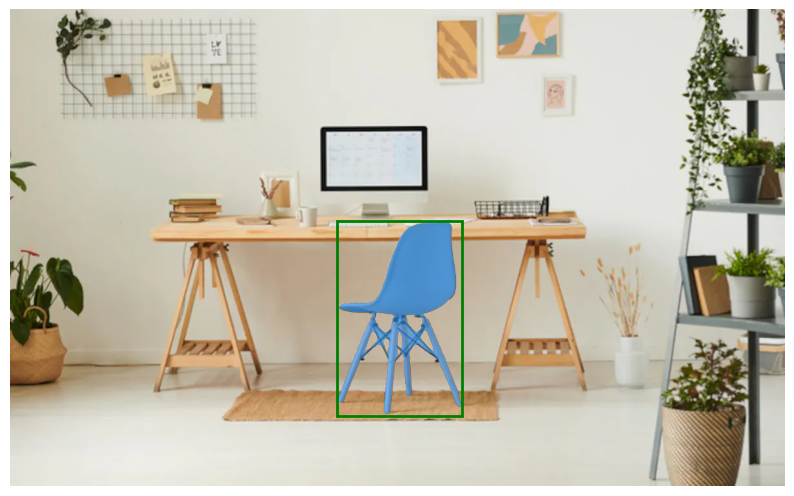

Bounding box: [508, 329, 191, 297]
Segmentation mask: [673, 329, 672, 330, 660, 330, 659, 331, 656, 331, 655, 330, 646, 330, 645, 331, 639, 331, 638, 332, 635, 332, 634, 333, 630, 333, 628, 335, 626, 335, 625, 336, 622, 336, 621, 337, 619, 337, 618, 338, 617, 338, 609, 346, 609, 347, 606, 350, 606, 351, 605, 352, 605, 353, 604, 354, 604, 355, 603, 356, 603, 357, 602, 358, 602, 359, 601, 360, 601, 361, 600, 362, 600, 364, 599, 365, 599, 367, 598, 368, 598, 369, 597, 370, 597, 371, 596, 372, 596, 373, 595, 374, 595, 375, 594, 376, 594, 378, 593, 379, 593, 380, 592, 381, 592, 383, 591, 384, 591, 386, 590, 387, 590, 389, 589, 390, 589, 392, 588, 393, 588, 395, 587, 396, 587, 398, 586, 399, 586, 401, 585, 402, 585, 405, 584, 406, 584, 409, 583, 410, 583, 413, 582, 414, 582, 416, 581, 417, 581, 419, 580, 420, 580, 422, 579, 423, 579, 424, 578, 425, 578, 427, 577, 428, 577, 429, 576, 430, 576, 433, 575, 434, 575, 435, 574, 436, 574, 437, 573, 438, 573, 439, 572, 440, 572, 441, 570, 443, 570, 

In [16]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt


def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)

    # Check if the image is loaded properly
    if image is None:
        raise ValueError(f"Unable to load image at path: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox=boxes.xyxy.tolist()[0]
    return bbox, image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

image_path = './images/study_room.webp'
model=YOLO('models/yolov8n.pt')
yolov8_boxex, image = yolov8_detection(model, image_path)

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_box = np.array(yolov8_boxex)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

for i, mask in enumerate(masks):
    # Convert the mask to a binary image    
    #binary_mask = mask.cpu().numpy().squeeze().astype(np.uint8)
    binary_mask = torch.from_numpy(masks).squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('bounding_boxe_NEW_137.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))

    mask=segmentation
    
    # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # write the yolo values to a text file
    with open('yolo_maskformat.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    print("Segmentation mask:", segmentation)

In [17]:
## multi object detection


0: 416x640 1 cup, 2 chairs, 6 potted plants, 1 tv, 1 vase, 58.7ms
Speed: 2.3ms preprocess, 58.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)
Bounding box: [508, 329, 191, 297]
yolo [    0.42333      0.4458     0.58167 ...     0.44715      0.5575     0.44715]
Bounding box: [1094, 370, 90, 109]
yolo [    0.91167     0.50136     0.98583      0.6477     0.97333     0.50136      0.9725     0.50271     0.97083     0.50271     0.96667     0.50949     0.96583     0.50949       0.965     0.50813     0.96333     0.50813      0.9625     0.50678     0.96167     0.50813     0.95917     0.50813     0.95833     0.50949
      0.9575     0.50949     0.95667     0.51084       0.955     0.51084     0.95417      0.5122      0.9525      0.5122     0.95083     0.51491        0.95     0.51491     0.94917     0.51626      0.9475     0.51626     0.94667     0.51491     0.94583     0.51491       0.945     0.51355       0.945      0.5122
     0.94417     0.51084     0.94417     0.50949    

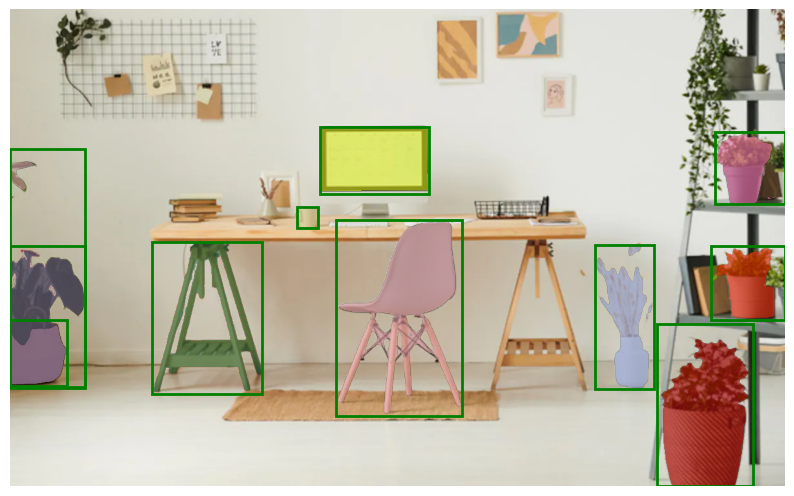

In [18]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image

image = cv2.imread('./images/study_room.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model=YOLO('models/yolov8n.pt')

yolov8_boxex, image = yolov8_detection(model, image_path)


sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
input_boxes = torch.tensor(yolov8_boxex, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

for i, mask in enumerate(masks):

    binary_mask = masks[i].squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation
    
        # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    #print("Segmentation mask:", segmentation)
    print("yolo",yolo)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()